In [21]:
import numpy as np
import matplotlib.pyplot as plt

def rectangle(x=0, y=0, width=1, length=1, step=.1, cetner=False):
    if cetner:
        x = -1*int(width/2)
        y = -1*int(length/2)
    step_inv = int(1 / step)
    vertices = [(x, y), (x + width, y), (x + width, y + length), (x, y + length)]
    # Generate the points along the edges of the square
    points = []
    for i in range(len(vertices)):
        x1, y1 = vertices[i]    
        x2, y2 = vertices[(i + 1) % len(vertices)]
        if x1 == x2:  # Vertical edge        
            points.extend([(x1, y * step, 1) for y in range(min(y1, y2)*step_inv, max(y1, y2)*step_inv + 1, 1)])
        else:  # Horizontal edge        
            points.extend([(x * step, y1, 1) for x in range(min(x1, x2)*step_inv, max(x1, x2)*step_inv + 1, 1)])
    vertices = [(x, y, 1), (x + width, y, 1), (x + width, y + length, 1), (x, y + length, 1)]
    return points, vertices
def projectivity(points, s, theta, tx, ty, v1, v2, v, K=[1,1,0,1]):
    theta = np.pi * theta / 180
    Hs = np.array([
        [s*np.cos(theta),   -s * np.sin(theta) ,        tx],
        [s*np.sin(theta),   s * np.cos(theta),          ty],
        [0,                 0,                          1]
    ])
    Ha = np.array([
        [K[0],K[1], 0],
        [K[2],K[3], 0],
        [0,   0,    1]
    ])
    Hp = np.array([
        [1 ,0,  0],
        [0 ,1,  0],
        [v1,v2, v]
    ])
    Hfinal = Hs @ Ha @ Hp
    transform_point = []
    for point in points:
        transform_point.append(Hfinal @ np.array(point).T)
        transform_point[-1] = [transform_point[-1][0]/transform_point[-1][2], transform_point[-1][1]/transform_point[-1][2], 1]
    return transform_point

def pro():
    points, vertices    = rectangle(x=1,y=2,width=10, length=10, cetner=True)
    points              = projectivity(points=points, s=1, theta=0, tx=0, ty=0, v1=.05, v2=.025, v=.5, K=[1, 1, 0, 1])
    vertices            = projectivity(points=vertices, s=1, theta=0, tx=0, ty=0, v1=.05, v2=.025, v=.5, K=[1, 1, 0, 1])
    return np.array(points), np.array(vertices)

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def AffineRecover(points, l1, l2, l3):
    Hpt = np.array([
        [1, 0,  -l1/l3],
        [0, 1,  -l2/l3],
        [0, 0,  1/l3]
    ])
    
    Hprime = affinity() @ np.linalg.inv(Hpt).T

    transform_point = []
    for point in points:
        transform_point.append(Hprime @ np.array(point).T)
        transform_point[-1] = [transform_point[-1][0]/transform_point[-1][2], transform_point[-1][1]/transform_point[-1][2], 1]
    return np.array(transform_point)


def affinity(theta=0, phi=0, lambda1=1, lambda2=1, tx=0, ty=0):
    D = np.array([
        [lambda1, 0],
        [0, lambda2]
    ])
    A = R(theta) @ R(-phi) @ D @ R(phi)
    aff_mat = np.array([
        [A[0][0], A[0][1], tx],
        [A[1][0], A[1][1], ty],
        [0,       0,        1]
    ])
    return aff_mat
    
def R(angle):
    angle = np.pi * angle / 180
    R = np.array([
        [np.cos(angle), -1*np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return R

In [24]:
points, corners = pro()
print(corners)

l1 = np.cross(corners[0], corners[1])
l2 = np.cross(corners[2], corners[3])

l3 = np.cross(corners[0], corners[3])
l4 = np.cross(corners[1], corners[2])

p1 = np.cross(l1, l2)
p2 = np.cross(l3, l4)

print(p1)
print(p2)

L = np.cross(p1, p2)
print(L.shape)

L[0] = L[0]/L[2]
L[1] = L[1]/L[2]
L[2] = 1
point_transformed = AffineRecover(points=points, l1=L[0], l2=L[1], l3=L[2])



[[-80.         -40.           1.        ]
 [  0.          -8.           1.        ]
 [ 11.42857143   5.71428571   1.        ]
 [  0.          13.33333333   1.        ]]
[19504.76190476     0.           975.23809524]
[19504.76190476 19504.76190476   487.61904762]
(3,)


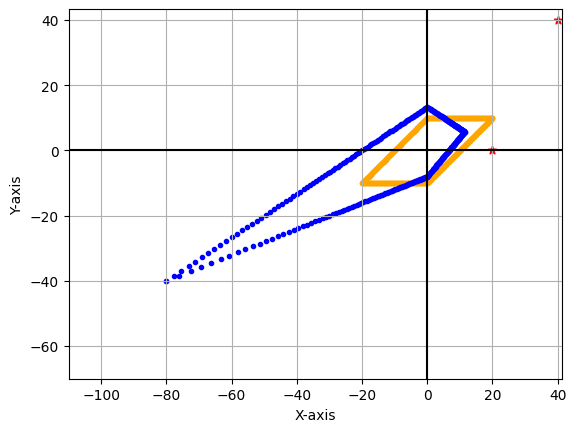

In [25]:
fig, ax = plt.subplots()

x_coords, y_coords, _ = zip(*point_transformed)
ax.scatter(x_coords, y_coords, marker='.', color='orange')


x_coords, y_coords, _ = zip(*points)
ax.scatter(x_coords, y_coords, marker='.', color='b')

p1[0] = p1[0]/p1[2]
p1[1] = p1[1]/p1[2]

p2[0] = p2[0]/p2[2]
p2[1] = p2[1]/p2[2]

ax.scatter(p1[0], p1[1], marker='*', color='r')
ax.scatter(p2[0], p2[1], marker='*', color='r')


# Set the axis limits
xlim = 30
ylim = 30
ax.set_xlim(min(x_coords) - xlim, max(x_coords) + xlim)
ax.set_ylim(min(y_coords) - ylim, max(y_coords) + ylim)
# Set the axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# Display the grid
ax.grid(True)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_aspect('equal', adjustable='box')
plt.show()